c:\Users\forc2101\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


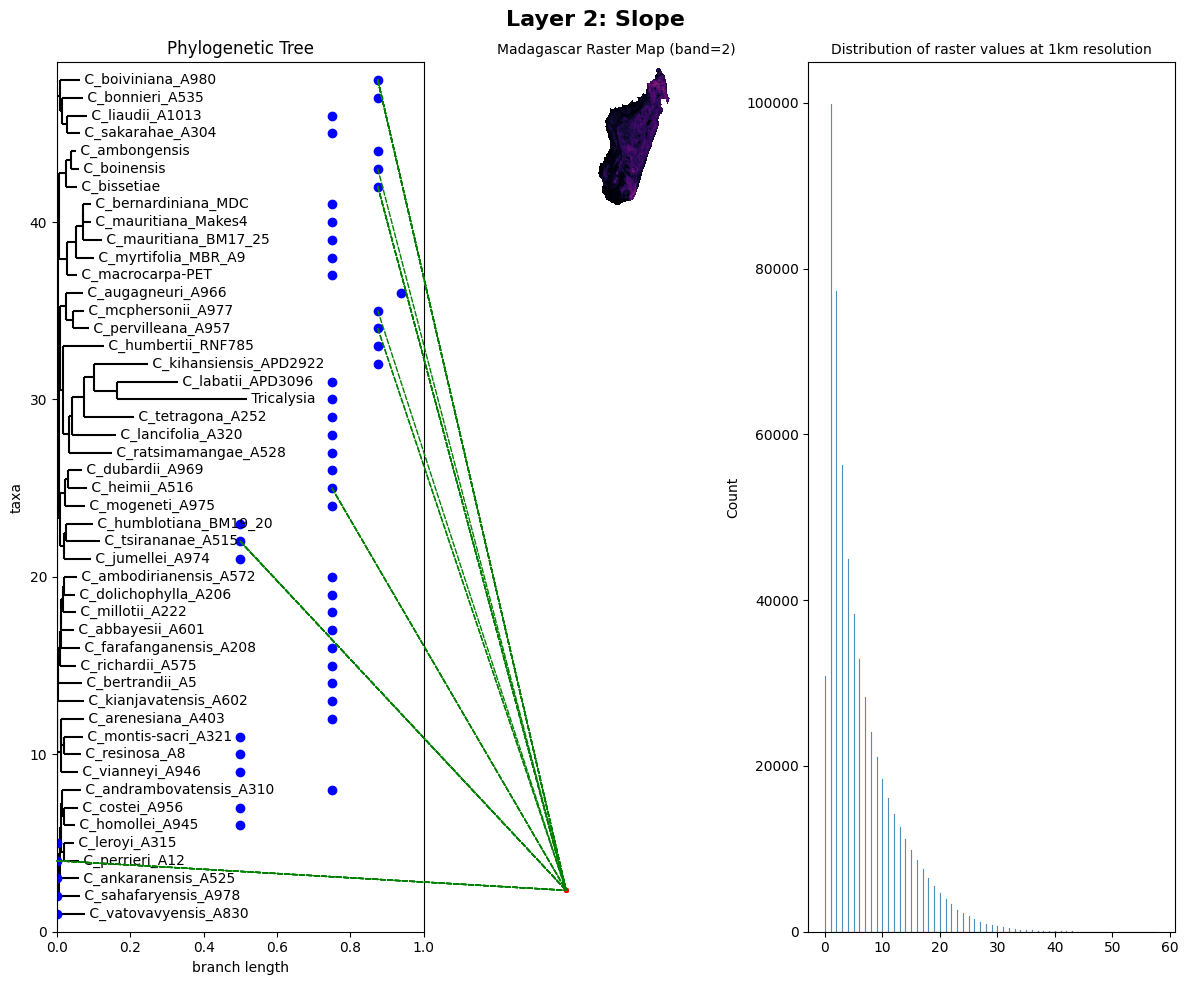

In [3]:
import csv
import pathlib
import inspect
from pathlib import Path
from typing import Optional, Union, List, Optional, Tuple, Dict
import time
from tqdm import tqdm
import re
import warnings

import py_madaclim
from py_madaclim._constants import Constants
from py_madaclim.info import MadaclimLayers

import rasterio
import rasterio.errors
import rasterio.plot
import pyproj
from pyproj import Transformer
import shapely
from shapely.geometry import Point
import geopandas as gpd

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable

#New
from matplotlib.patches import ConnectionPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from Bio import Phylo
from rasterio.plot import show

#import matplotlib.pyplot as plt
#import rasterio

#import numpy as np
nwk_file = "../tree/new_phylo_tree.nwk"
offsets_file = "../data/offset0.csv"

# Open our raster dataset
raster = rasterio.open(r"C:\Users\forc2101\OneDrive - USherbrooke\IFT809\IFT809\py_madaclim\madaclim_enviro.tif")
band_num = 2
band_data = raster.read(band_num, masked=True)


# Continous data for multi plots
subplots_figsize = (12, 10)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=subplots_figsize)


# Phylogenetic tree creation



# --------------------------------------
# ------------  Phylogenetic MAP -------
# --------------------------------------

def custom_label(clade):
    if clade.is_terminal():
        return clade.name
    else:
        return None

def calc_node_positions(tree, x_start, x_end, y_start, y_step):
    if tree.is_terminal():
        x_pos = x_start
        y_pos = y_start
        y_start += y_step
    else:
        x_pos = (x_start + x_end) / 2
        y_pos = y_start

        child_y_start = y_start
        for child in tree.clades:
            child_x_pos, child_y_pos, y_start = calc_node_positions(child, x_start, x_end, y_start, y_step)
            x_start = child_x_pos

        y_pos = (y_start + child_y_start) / 2

    tree.position = (x_pos, y_pos)
    return x_pos, y_pos, y_start

def get_x_offset(node_name, offsets_dict):
    return offsets_dict.get(node_name, 0)  # default offset is 0 if not found

def plot_adjusted_node(ax, node, y_offset, offsets_dict):
    x, y = node.position
    x_offset = get_x_offset(node.name, offsets_dict)
    x += x_offset
    y += y_offset
    ax.plot(x, y, 'bo')
    return x, y

# Load the tree
tree = Phylo.read(nwk_file, "newick")

# Load offsets from CSV
offsets_df = pd.read_csv(offsets_file)
offsets_dict = pd.Series(offsets_df.XOffset.values, index=offsets_df.NodeName).to_dict()

# Calculate positions for all nodes
y_step = 1
calc_node_positions(tree.root, 0, 1, 0, y_step)

# Create a figure for the subplot
#ax_tree = fig.add_subplot(121)

# Plot the tree
Phylo.draw(tree, do_show=False, axes=axes[0], label_func=custom_label)
axes[0].set_title("Phylogenetic Tree")

# Set axes limits to verify the data range
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, max(node.position[1] for node in tree.get_terminals()) + 2)

node_positions = {clade.name: clade.position for clade in tree.find_clades()}

# Generate DataFrame with node coordinates
rows = []
for clade in tree.find_clades():
    if clade.is_terminal():
        label = clade.name
        x, y = plot_adjusted_node(axes[0], clade, y_step, offsets_dict)  # Adjust offsets if necessary
        rows.append([label, (x, y)])

# Create DataFrame with node coordinates
df = pd.DataFrame(rows, columns=["ID", "Coordinates"])

# --------------------------------------
# ------------  GRAPH MAP --------------
# --------------------------------------

gps = pd.read_csv('../data/sample_data_mada.csv')
geometry = [Point(xy) for xy in zip(gps["longitude"], gps["latitude"])]
gdf = gpd.GeoDataFrame(gps, geometry=geometry)

# Define the CRS for the GeoDataFrame
gdf.crs = 'EPSG:32738'  # Assuming the GPS data is in WGS 84
# Calculate extent of raster



left, bottom, right, top = raster.bounds

rasterio.plot.show(band_data.squeeze(), ax=axes[1], cmap="inferno", extent=[left, right, bottom, top])    # Use rasterio.plot.show() instead                
im = axes[1].get_images()[0]  # get the first image
                
# Colorbar customization
divider = make_axes_locatable(axes[1])

axes[1].set_title(f"Madagascar Raster Map (band={band_num})", fontsize=10)
axes[1].set_yticks([])
axes[1].set_xticks([])
axes[1].axis("off")

# Plot points from GPS dataframe on the map
for index, row in gps.iterrows():
    axes[1].plot(row["longitude"], row["latitude"], 'ro', markersize=1)



#with rasterio.open(raster) as src:
 #   gdf = gdf.to_crs(src.crs)


# Create a figure and axis for the plot
#extent = [43, 51, -27, -11]
#axes[1].set_extent(extent)

# Plot the first layer of the TIFF as the background
#with rasterio.open(raster) as src:
#    axes[1].imshow(src.read(1), extent=extent, transform=ccrs.PlateCarree(), origin='upper')#, cmap='viridis')

# Plot the GeoDataFrame points on the raster
gdf.plot(ax=axes[1], marker='o', color='red', markersize=5)

""" points = [(48.380066,-19.189873), (44.272222,-22.853611), (46.145833,-24.303611)]

# convert points to geodataframe
#gdf = gpd.geodataframe(geometry=gpd.points_from_xy([p[0] for p in points], [p[1] for p in points]))
gdf = gpd.geodataframe(geometry=[point(p) for p in points], crs='epsg:4326')
gdf = gdf.to_crs(raster.crs)
# plot the points on the raster
gdf.plot(ax=axes[1], color='red', markersize=15)   """              
                
# Plot histogram of raster vals
sns.histplot(
                    data=band_data.compressed(),
                    ax=axes[2]
                    
                )
#axes[2].lines[0].set_color("black")
axes[2].set_title("Distribution of raster values at 1km resolution", fontsize=10)
#axes[2].set_xlabel(layer_units)

fig.suptitle(
                f"Layer {band_num}: {"Slope"}",
                fontsize=16,
                weight="bold",
                ha="center"
            )


# --------------------------------------
# ------------  Line mapping -----------
# --------------------------------------

# Group gps DataFrame by ID and create a dictionary of lists of coordinates
gps_grouped = gps.groupby('specimen_id')[['longitude', 'latitude']].apply(lambda x: list(zip(x['longitude'], x['latitude']))).to_dict()

# Iterate through each row in df to create connection patches
for index, row in df.iterrows():
    # Get corresponding list of coordinates from gps DataFrame
    if row['ID'] in gps_grouped:
        species_coords_list = gps_grouped[row['ID']]
        # Create connection patches for each coordinate in the list
        for species_coords in species_coords_list:
            con = ConnectionPatch(
                xyA=row['Coordinates'], coordsA="data",
                xyB=species_coords, coordsB="data",
                axesA=axes[0], axesB=axes[1],
                color="green", linewidth=1, linestyle="--",
                zorder=2
            )
            fig.add_artist(con)
            
fig.tight_layout()
